In [36]:
from dotenv import load_dotenv
load_dotenv()

True

In [37]:
#setup API key
import os
OPENAI_API_KEY=os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")

In [38]:
#Setting up the environmet key
os.environ["OPENAI_API_KEY"]=OPENAI_API_KEY
os.environ["TAVILY_API_KEY"]=TAVILY_API_KEY

In [34]:
#Lets import the required libraries
import pandas as pd
from langgraph.graph import StateGraph,MessagesState, START, END
from langgraph.graph.message import add_messages
# from typing import Annotated, Literal, List   #
from typing_extensions import TypedDict, Annotated, Literal, List
from langchain_core.tools import tool    #for creating Tool
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver   #To sustain the memory
from langgraph.prebuilt import ToolNode,tools_condition     #To create the Nodes for Tool
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import TavilySearchResults

In [5]:
#Load the model
from langchain_openai import ChatOpenAI
openai_model=ChatOpenAI(model="gpt-4o")

In [6]:
openai_model.invoke('Hi, My Name is Yaseen')

AIMessage(content='Hello Yaseen! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 15, 'total_tokens': 27, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BdE31QrZH3SOB6kfhIh0GwwPkuYwY', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--c1f317e5-16b5-4aab-be92-39394409872b-0', usage_metadata={'input_tokens': 15, 'output_tokens': 12, 'total_tokens': 27, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [7]:
#We have our model ready, now lets create a Tool

In [8]:
class AgentState(TypedDict):
    messages: Annotated[list, add_messages]
    meetings: list[dict]  # <- This will store the output of load_meeting_data
    analysis: list[str]


In [9]:
#Load meeting data
@tool
def load_meeting_data() -> List[TypedDict]:
    """Tool to load meeting data from a CSV file."""
    df = pd.read_csv("yaseen_khan_missed_meetings_2.csv")
    df = df[0:5]
    meetings = df.to_dict(orient="records")
    return {"meetings": meetings}

In [10]:
#@tool
def analyze_meetings_batch(state: AgentState) -> list[str]:
    """Analyzes multiple meetings and returns summaries for each."""
    meetings = state.get("meetings", [])
    results = []

    for i, meeting in enumerate(meetings, 1):
        mom = meeting.get("MOM Content", "")
        transcript = meeting.get("Transcript Content", "")

        if mom:
            content = f"MoM:\n{mom}"
        elif transcript:
            content = f"Transcript:\n{transcript}"
        else:
            results.append(f"Meeting {i}: No MoM or Transcript available.")
            continue

        prompt = f"""
        You're an AI assistant of User, responsible for analyzing meeting content which he missed during his leave.
        Your task is to read the content of the meeting, analyze it, and recommend actions such as tasks to complete, follow-up meetings to schedule, or status updates to provide.
        You will be provided with the content of the meeting, and you should summarize it in a concise manner.
        Meeting {i} content:
        {content}
        """
        response = openai_model.invoke(prompt)
        results.append(f"Meeting {i} Summary:\n{response.content.strip()}")

    return {"analysis": results}


In [39]:
tavily_tool = TavilySearchResults()

In [51]:
tavily_tool.invoke("What is the latest news about AI?")

[{'title': 'Artificial Intelligence - Latest AI News and Analysis - WSJ.com',
  'url': 'https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAj7gxrm58ILGVuyS8pIl3MuqFXHE_ATCBwK6rshSBVTvnmQ4LlbD5O0&gaa_ts=683ae82c&gaa_sig=Lf986i8425pPHrE83HkbfWR1RyDxxTBmCHCYJ6nPG5BfN6Cv5JMWTSbXBxbuGPEHd6lzba-vMOurk-lm-TXYrA%3D%3D',
  'content': 'The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technology.',
  'score': 0.74697095},
 {'title': 'AI News | Latest AI News, Analysis & Events',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': "Huawei Supernode 384 disrupts Nvidia's AI market hold. Telegram logo as the company forges a deal with Elon Musk's xAI to weave Grok AI.",
  'score': 0.72675586},
 {'title': 'Artificial Intelligence News - ScienceDaily',
  'url': 'https://www.sciencedaily.com/news/computers_math/artificial_intelligence/',
  'content': '![ScienceDaily](/images/sd-logo.png)\n\n# Artificial Intelligence News\

In [98]:
#@tool
def internet_search(state: AgentState) -> TypedDict:
    """Search the internet for latest information."""
    question=state["messages"]
    response=tavily_tool.invoke(question)
    return {"messages":response}
    

In [99]:
result = internet_search({"messages": "what is the latest news about AI?"})
print(result)

{'messages': [{'title': 'Artificial Intelligence - Latest AI News and Analysis - WSJ.com', 'url': 'https://www.wsj.com/tech/ai?gaa_at=eafs&gaa_n=ASWzDAh9D2IiRji5RPGtZt65eqxK_Q7W0uszgcNNpnXWw5T86-Vg-t0hBWEZ&gaa_ts=683aee36&gaa_sig=FLWhhMpRf7wJfxsx2vaf4yIKQL_NhyqCZfhjIEuSX2zpaZCPYG3ZZbMNR04MKbVMbBtfg0oKKgCoDT01_YrkBg%3D%3D', 'content': 'The latest artificial intelligence news coverage focusing on the technology, tools and the companies building AI technology.', 'score': 0.75723875}, {'title': 'Artificial intelligence - NBC News', 'url': 'https://www.nbcnews.com/artificial-intelligence', 'content': "Profile\n\nSections\n\nLocal\n\ntv\n\nFeatured\n\nMore From NBC\n\nFollow NBC News\n\nnews Alerts\n\nThere are no new alerts at this time\n\n# ARTIFICIAL INTELLIGENCE\n\nThe latest news and top stories on artificial intelligence, including ChatGPT, AI Chatbot and Bard.\n\n![](https://media-cldnry.s-nbcnews.com/image/upload/t_focal-762x508,f_auto,q_auto:best/rockcms/2025-05/250529-artificial-in

In [59]:
#Defing the tool name as below
tools=[load_meeting_data,internet_search]

In [60]:
#We are binding the tool
llm_with_tool=openai_model.bind_tools(tools)

In [18]:
response=llm_with_tool.invoke("My Name is Yaseen Khan")
response

AIMessage(content='Hello Yaseen Khan! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 80, 'total_tokens': 94, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BdE4w2iRlOtlAZ1f9bLjgH1UGXy08', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--ab5dd225-bd05-4c22-b698-1a073fef216e-0', usage_metadata={'input_tokens': 80, 'output_tokens': 14, 'total_tokens': 94, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [61]:
response=llm_with_tool.invoke("Who won ipl 2025 qualifier 1?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_NncEs9dP0N0ZKF88dRBlremk', 'function': {'arguments': '{"state":{"messages":[{"role":"user","content":"Who won ipl 2025 qualifier 1?"}],"analysis":["The user\'s query is a request for information about a specific sporting event: the winner of the IPL 2025 Qualifier 1 match.","This is recent sports information that is likely to be found online.","Utilizing the internet search tool is appropriate to find the latest results of the IPL 2025."]}}', 'name': 'internet_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 84, 'total_tokens': 183, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BdEiMnnNHbwgobzTTI

In [ ]:
response=llm_with_tool.invoke("can you load the meeting data?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_WCFXZpnzCozmjrQTxhvcjtyV', 'function': {'arguments': '{}', 'name': 'load_meeting_data'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 50, 'total_tokens': 62, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_07871e2ad8', 'id': 'chatcmpl-BcfF1NzOTmCIUjGueFe3c3u5F1Qm1', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8d1d0990-7411-4cc6-8b2a-bea21a24da4f-0', tool_calls=[{'name': 'load_meeting_data', 'args': {}, 'id': 'call_WCFXZpnzCozmjrQTxhvcjtyV', 'type': 'tool_call'}], usage_metadata={'input_tokens': 50, 'output_tokens': 12, 'total_tokens': 62, 'input_token_details': {'audio': 0, 'cache_read': 0},

In [ ]:
llm_with_tool.invoke("can you load the meetings?").tool_calls

[{'name': 'load_meeting_data',
  'args': {},
  'id': 'call_jt4Ll4BEy88giLvXPz4My9Et',
  'type': 'tool_call'}]

In [ ]:
llm_with_tool.invoke("can you load and analyse the meetings?").tool_calls

[{'name': 'load_meeting_data',
  'args': {},
  'id': 'call_tRv3E7lfwCzeBjWtzJvDzUiR',
  'type': 'tool_call'}]

In [62]:
llm_with_tool.invoke("Who won ipl 2025 qualifier 1?").tool_calls

[{'name': 'internet_search',
  'args': {'state': {'messages': [{'role': 'user',
      'content': 'Who won ipl 2025 qualifier 1?'}],
    'analysis': ['The user is asking about a specific match in the IPL 2025, particularly the winner of Qualifier 1.',
     "This requires up-to-date information beyond the system's last training data.",
     'I will perform an internet search to find out the winner of IPL 2025 Qualifier 1.']}},
  'id': 'call_efbgASYteXSam9TdNB6rTzJq',
  'type': 'tool_call'}]

In [74]:
from langchain_core.messages import HumanMessage, SystemMessage
# System message
sys_msg = SystemMessage(content="You are a helpful assistant interact with user gently, enables internet search and upon asked you will load the meeting data and analyze it to provide recommendations.")


In [75]:
#Defining the supervisor node as our llm
def call_model(state:AgentState) -> dict:
    question=state["messages"][-1]  # Get the last message from the state
    response=llm_with_tool.invoke([sys_msg]+question)  #instead of invoking the normal llm , we are using the binding llm which is binded to a tool
    return {"messages":[response]}

In [76]:
# #lets ask a simpe query
# input={'messages': ['load the outlook data']}  #quer
# response=call_model(input)  #call the function with query and store the resul in response variable
# message=response["messages"]  #Take only messages from response
# last_message=message[-1]  #Take the last message from all the messages
# last_message

In [77]:
tools

[StructuredTool(name='load_meeting_data', description='Tool to load meeting data from a CSV file.', args_schema=<class 'langchain_core.utils.pydantic.load_meeting_data'>, func=<function load_meeting_data at 0x0000027764BE23E0>),
 <function __main__.internet_search(state: __main__.AgentState) -> <function TypedDict at 0x000002775B1309A0>>]

In [78]:
#Note: we have to create this tool as node for orchaestration pupose
# for this tool to consume it as node inside our workflow, we have use this method below
tool_node=ToolNode(tools)

#now this "tool_node" variable is the node of our tool which can be used in orchaestrtion

In [79]:
#Lets define a router and orchaestrate the workflow
def router_function(state: AgentState):    #-> Literal["tools", END]
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END

In [80]:
#Lets create the workflow with this router
workflow=StateGraph(AgentState)

In [81]:
#create the nodes
workflow.add_node("assistant",call_model)
workflow.add_node("load_meetings", tool_node)#Consuming tool as node
workflow.add_node("analyze_meetings", analyze_meetings_batch)


In [82]:
#Define the endges (conditional edges )
workflow.add_edge(START, "assistant")

workflow.add_conditional_edges("assistant",
                               router_function,
                               {"tools": "load_meetings", END:END})
workflow.add_edge("load_meetings", "analyze_meetings")
workflow.add_edge("analyze_meetings", "assistant")
workflow.add_edge("assistant", END)




In [83]:
#Lets compile
memory_saver = MemorySaver()
from uuid import uuid4
session_id = str(uuid4())

app = workflow.compile(checkpointer=memory_saver)

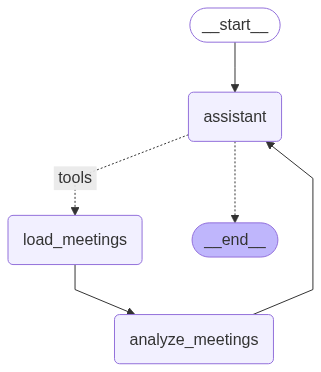

In [84]:
#Lets visualize the graph
from IPython.display import Image,display
display(Image(app.get_graph().draw_mermaid_png()))

In [85]:
#Now lets invoke this app

#invoking with a simple message
# message=[HumanMessage(content="My Name is Yaseen Khan")]
# response=app.invoke({"messages": message}, config={"configurable": {"thread_id": session_id}})
# response

#Here we are getting the AI message from LLM (assistant) directly as this is simple query

In [ ]:
message=[HumanMessage(content="who won the qaulifier 1 of ipl 2025?")]
response=app.invoke({"messages": message},config={"configurable": {"thread_id": session_id}})
response

TypeError: can only concatenate list (not "HumanMessage") to list

In [87]:
message=[HumanMessage(content="can you load the meeting data and analyse each meeting and recommend the action itmes in each meeting?")]
response=app.invoke({"messages": message},config={"configurable": {"thread_id": session_id}})
response


TypeError: can only concatenate list (not "HumanMessage") to list

In [ ]:
res=response['messages'][-1].pretty_print()


================================== Ai Message ==================================

I've loaded the meeting data. Here's an analysis and recommended action items for each meeting:

1. **Meeting ID: MTG0001 - Whiteboard Web-Enabled Roi**
   - **Type:** Retrospective
   - **Action Items:**
     - Prepare a detailed analytics report.
     - Escalate unresolved issues to IT support.
     - Arrange a session on data compliance practices.
   - **Recommendation:** Ensure all team members have access to necessary data and resources for reporting.

2. **Meeting ID: MTG0002 - Deliver Frictionless E-Markets**
   - **Type:** Team Sync
   - **Action Items:**
     - Escalate unresolved issues to IT support.
     - Validate changes with the QA team.
     - Update the project plan with new timelines.
   - **Recommendation:** Coordinate with IT and QA team to address blockages swiftly and align updated timelines with stakeholders.

3. **Meeting ID: MTG0003 - Envisioneer Front-End Supply-Chains**
   - **T

In [ ]:
for m in response["messages"]:
    m.pretty_print()

================================ Human Message =================================

can you load the meeting data and analyse each meeting and recommend the action itmes in each meeting?
================================== Ai Message ==================================
Tool Calls:
  load_meeting_data (call_yEa8TWJ1QFpSHY1JzQtPRJi6)
 Call ID: call_yEa8TWJ1QFpSHY1JzQtPRJi6
  Args:
================================= Tool Message =================================
Name: load_meeting_data

{"meetings": [{"Meeting_ID": "MTG0001", "Title": "Whiteboard Web-Enabled Roi", "Date_Time": "4/27/2025 12:00", "Duration": 15, "Attendees": "Yaseen Khan, Lauren Raymond, James Mccoy, Mrs. Amanda Barron, Kelsey Clayton, Jose Parker, Sarah Hall", "Organizer": "Tim Brown", "Location/Link": "Microsoft Teams", "Meeting Type": "Retrospective", "Missed by User": true, "Has MOM": true, "Has Transcript": false, "MOM Content": "Meeting Summary:\nThe team reviewed the quarterly sales performance and discussed areas for im